<a href="https://colab.research.google.com/github/Eleyaraja/optiNET_Ai/blob/main/Copy_of_eyediseasefinalprj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, models, applications, Model, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import gc
import time

In [ ]:
 # Set random seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Enable mixed precision for faster training
set_global_policy('mixed_float16')

# Parameters
IMG_SIZE = 456  # Target image size
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-4
AUTOTUNE = tf.data.experimental.AUTOTUNE



# Dataset path
DATASET_PATH = "/content/drive/MyDrive/retinal_disease_project/Augmented Dataset"  # Adjust path as needed

# Create a list to store class names and sample counts
class_info = []

# Function to load and analyze the dataset
contac us for this code

Found 9 classes: ['Myopia', 'Central Serous Chorioretinopathy-Color Fundus', 'Glaucoma', 'Disc Edema', 'Diabetic Retinopathy', 'Retinitis Pigmentosa', 'Macular Scar', 'Retinal Detachment', 'Healthy']


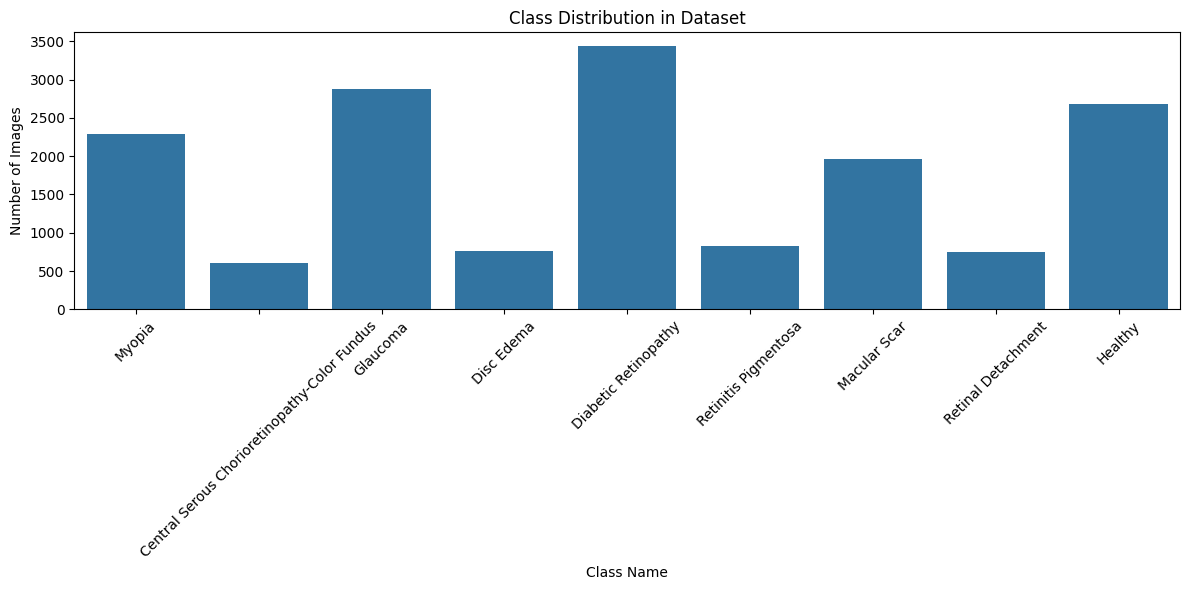

Class distribution:
Myopia: 2295 images
Central Serous Chorioretinopathy-Color Fundus: 606 images
Glaucoma: 2880 images
Disc Edema: 762 images
Diabetic Retinopathy: 3444 images
Retinitis Pigmentosa: 834 images
Macular Scar: 1966 images
Retinal Detachment: 750 images
Healthy: 2676 images

Imbalance ratio (max/min): 5.68
Dataset is imbalanced. Will use class weights or CategoricalFocalCrossentropy.
Class weights: {0: np.float64(0.7849431130476882), 1: np.float64(2.972680601393473), 2: np.float64(0.6255015432098765), 3: np.float64(2.3641003207932343), 4: np.float64(0.5230674925796877), 5: np.float64(2.1600053290700774), 6: np.float64(0.9162993105007348), 7: np.float64(2.401925925925926), 8: np.float64(0.6731855173559209)}


In [ ]:
# Load and analyze dataset
image_paths, labels, class_names = analyze_dataset(DATASET_PATH)

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)


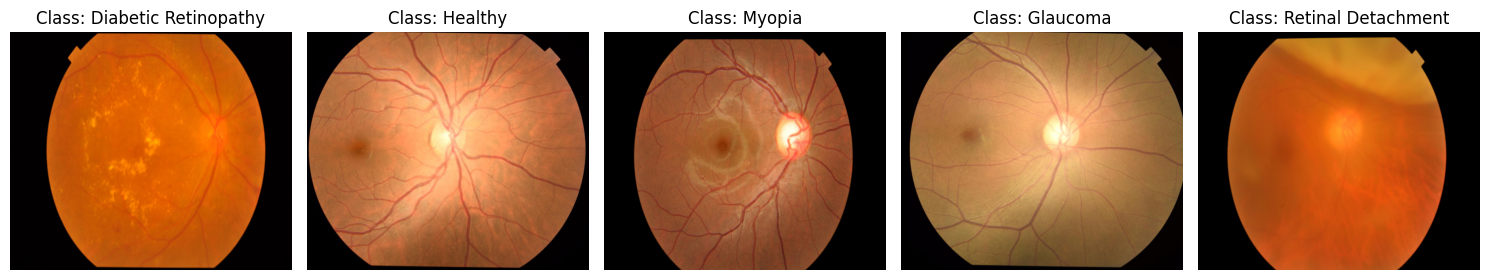

In [ ]:
# Split the dataset
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)

# Let's examine a few sample images
def show_sample_images(image_paths, labels, class_names, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    random_indices = np.random.randint(0, len(image_paths), num_samples)

    for i, idx in enumerate(random_indices):
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_names[labels[idx]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images(image_paths, labels, class_names)

In [ ]:
# Image preprocessing functions



In [ ]:
def parse_image(image_path, label):
    image_path = image_path.numpy().decode('utf-8')
    image = preprocess_image(image_path)

    # If image is None, return a dummy image and label instead of None
    if image is None:
        image = tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.float32)  # Dummy image
        label = tf.constant(0, dtype=tf.int32)  # Dummy label (index 0)
    else:
        label = tf.constant(label, dtype=tf.int32)  # Make sure label is a tensor

    # One-hot encode the label
    label = tf.one_hot(label, depth=len(class_names))

    return image, label

def tf_parse_image(image_path, label):
    result = tf.py_function(
        parse_image, [image_path, label], [tf.float32, tf.float32]
    )
    image, label = result
    image.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label.set_shape([len(class_names)])  # Set shape for one-hot encoded label
    return image, label




In [ ]:
# Create augmentation layer
def get_augmentation_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Random brightness and contrast
Reduced factor

    # Random zoom
    x = tf.keras.layers.RandomZoom(
        height_factor=(-0.05, 0.05),  # Reduced range
        width_factor=(-0.05, 0.05)   # Reduced range
    )(x)

    # Random flip
    x = tf.keras.layers.RandomFlip(mode="horizontal")(x)
    x = tf.keras.layers.RandomFlip(mode="vertical")(x)

    # Random rotation
    x = tf.keras.layers.RandomRotation(factor=0.05)(x)  # Reduced factor

    return tf.keras.Model(inputs=inputs, outputs=x)

augmentation_model = get_augmentation_model()




In [ ]:
# Create TF datasets
# Create TF datasets with better error handling
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(tf_parse_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE)
train_ds = train_ds.map(
    lambda x, y: (augmentation_model(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)
train_ds = train_ds.prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(tf_parse_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)



Showing augmented samples:


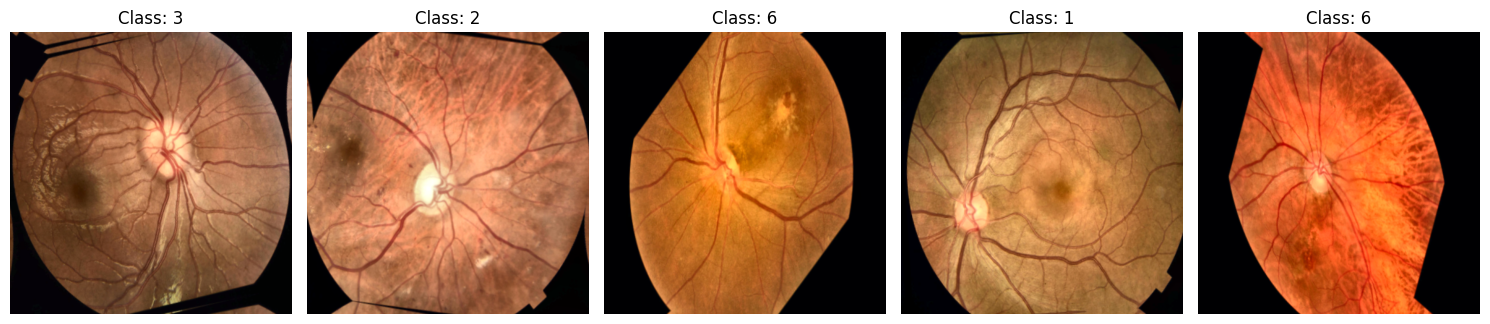

In [ ]:
def show_augmented_samples(dataset, num_samples=5):
    import matplotlib.pyplot as plt
    import numpy as np
    import cv2  # Only if needed

    plt.figure(figsize=(15, 5))

    for images, labels in dataset.take(1):
        for j in range(min(num_samples, images.shape[0])):
            img = images[j].numpy()

            # Rescale from 0-1 to 0-255 if needed
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)  # Ensure uint8 data type

            # Remove if your pipeline already gives RGB (common for TensorFlow datasets)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Handle one-hot or sparse labels
            label = labels[j].numpy()
            if label.ndim > 0 and len(label) > 1:
                label = np.argmax(label)

            plt.subplot(1, num_samples, j+1)
            # Convert the image to a suitable data type for imshow
            plt.imshow(img.astype(np.float32)) # or img.astype(np.uint8) if you rescaled
            plt.title(f"Class: {label}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()



print("Showing augmented samples:")
show_augmented_samples(train_ds)



In [ ]:
# Define Squeeze-and-Excitation block
def se_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]

    se = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    se = tf.keras.layers.Reshape((1, 1, filters))(se)
    se = tf.keras.layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal')(se)

    return tf.keras.layers.multiply([input_tensor, se])



In [ ]:
# Define CBAM (Convolutional Block Attention Module)
def cbam_block(input_tensor, ratio=16):
    # Channel attention
    channel_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    channel_max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)

    channel_avg_pool = tf.keras.layers.Reshape((1, 1, input_tensor.shape[-1]))(channel_avg_pool)
    channel_max_pool = tf.keras.layers.Reshape((1, 1, input_tensor.shape[-1]))(channel_max_pool)

    channel_dense_1 = tf.keras.layers.Dense(input_tensor.shape[-1] // ratio, activation='relu')
    channel_dense_2 = tf.keras.layers.Dense(input_tensor.shape[-1], activation='sigmoid')

    channel_avg = channel_dense_2(channel_dense_1(channel_avg_pool))
    channel_max = channel_dense_2(channel_dense_1(channel_max_pool))

    channel_attention = tf.keras.layers.add([channel_avg, channel_max])
    channel_refined = tf.keras.layers.multiply([input_tensor, channel_attention])

    # Spatial attention
    spatial_avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=-1, keepdims=True))(channel_refined)
    spatial_max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=-1, keepdims=True))(channel_refined)

    spatial_concat = tf.keras.layers.Concatenate()([spatial_avg_pool, spatial_max_pool])
    spatial_attention = tf.keras.layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(spatial_concat)

    refined = tf.keras.layers.multiply([channel_refined, spatial_attention])

    return refined

In [ ]:
 # Build model with Functional API


In [ ]:
# Build the model
model, base_model = build_model(len(class_names), use_se=True, use_cbam=False)

# Model summary
model.summary()

# Set up callbacks
checkpoint_path = "/content/drive/MyDrive/path_to/checkpoints"
os.makedirs(checkpoint_path, exist_ok=True)

callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_path, 'best_model.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_path, 'model_epoch{epoch:02d}.h5'),
        save_freq='epoch',
        #period=5,  # Remove or replace with save_freq
        verbose=1,
          # Save every 5 epochs
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    TensorBoard(
        log_dir='/content/drive/MyDrive/path_to/logs',
        update_freq='epoch'
    )
]

# Compile model with Focal Loss to handle class imbalance
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=CategoricalFocalCrossentropy(gamma=2.0),
    metrics=['accuracy']
)


52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 456, 456,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b3   │ (None, 15, 15,    │ 12,930,622 │ input_layer_2[0]… │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ global_average_p… │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 96)  │    147,552 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1,      │    148,992 │ dense[0][0]       │
│                     │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 15, 15,    │          0 │ efficientnetv2-b… │
│                     │ 1536)             │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1536)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    393,472 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 9)         │      2,313 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,622,951 (51.97 MB)

 Trainable params: 692,329 (2.64 MB)

 Non-trainable params: 12,930,622 (49.33 MB)

In [ ]:
# Phase 1: Train the classifier head
print("Phase 1: Training classifier head with frozen backbone...")
phase1_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

# Phase 2: Fine-tune the model
print("Phase 2: Fine-tuning the model...")
# Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),
    loss=CategoricalFocalCrossentropy(gamma=2.0),
    metrics=['accuracy']
)

# Continue training
phase2_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=invalid,
    callbacks=invalid,
    class_weight=class_weight_dict,
    initial_epoch=len(phase1_history.history['])
)


Phase 1: Training classifier head with frozen backbone...
Epoch 1/15
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1013 - loss: 0.4784
Epoch 1: val_accuracy improved from -inf to 0.12118, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 1: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch01.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 1938s 2s/step - accuracy: 0.1013 - loss: 0.4784 - val_accuracy: 0.1212 - val_loss: 0.4683 - learning_rate: 1.0000e-04
Epoch 2/15
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.0972 - loss: 0.4705
Epoch 2: val_accuracy improved from 0.12118 to 0.21246, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 2: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch02.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 146s 177ms/step - accuracy: 0.0972 - loss: 0.4705 - val_accuracy: 0.2125 - val_loss: 0.4620 - learning_rate: 1.0000e-04
Epoch 3/15
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1079 - loss: 0.4633
Epoch 3: val_accuracy did not improve from 0.21246

Epoch 3: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch03.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.1079 - loss: 0.4633 - val_accuracy: 0.0373 - val_loss: 0.4596 - learning_rate: 1.0000e-04
Epoch 4/15
810/811 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1120 - loss: 0.4589
Epoch 4: val_accuracy did not improve from 0.21246

Epoch 4: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch04.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 176ms/step - accuracy: 0.1120 - loss: 0.4589 - val_accuracy: 0.0373 - val_loss: 0.4547 - learning_rate: 1.0000e-04
Epoch 5/15
809/811 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.1017 - loss: 0.4558
Epoch 5: val_accuracy did not improve from 0.21246

Epoch 5: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch05.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.1017 - loss: 0.4558 - val_accuracy: 0.0373 - val_loss: 0.4524 - learning_rate: 1.0000e-04
Epoch 6/15
809/811 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1088 - loss: 0.4512
Epoch 6: val_accuracy did not improve from 0.21246

Epoch 6: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch06.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.1088 - loss: 0.4512 - val_accuracy: 0.2125 - val_loss: 0.4472 - learning_rate: 1.0000e-04
Epoch 7/15
810/811 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.1237 - loss: 0.4460
Epoch 7: val_accuracy did not improve from 0.21246

Epoch 7: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch07.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.1236 - loss: 0.4460 - val_accuracy: 0.0373 - val_loss: 0.4425 - learning_rate: 1.0000e-04
Epoch 8/15
810/811 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.0878 - loss: 0.4451
Epoch 8: val_accuracy did not improve from 0.21246

Epoch 8: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch08.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.0878 - loss: 0.4451 - val_accuracy: 0.0373 - val_loss: 0.4416 - learning_rate: 1.0000e-04
Epoch 9/15
810/811 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.1124 - loss: 0.4426
Epoch 9: val_accuracy did not improve from 0.21246

Epoch 9: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch09.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.1124 - loss: 0.4426 - val_accuracy: 0.1212 - val_loss: 0.4378 - learning_rate: 1.0000e-04
Epoch 10/15
810/811 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1209 - loss: 0.4396
Epoch 10: val_accuracy did not improve from 0.21246

Epoch 10: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch10.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.1209 - loss: 0.4396 - val_accuracy: 0.2125 - val_loss: 0.4375 - learning_rate: 1.0000e-04
Epoch 11/15
809/811 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.1016 - loss: 0.4381
Epoch 11: val_accuracy did not improve from 0.21246

Epoch 11: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch11.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 143s 175ms/step - accuracy: 0.1015 - loss: 0.4381 - val_accuracy: 0.0373 - val_loss: 0.4390 - learning_rate: 1.0000e-04
Epoch 12/15
810/811 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.0905 - loss: 0.4366
Epoch 12: val_accuracy did not improve from 0.21246

Epoch 12: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch12.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.0905 - loss: 0.4366 - val_accuracy: 0.0373 - val_loss: 0.4384 - learning_rate: 1.0000e-04
Epoch 13/15
810/811 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.0807 - loss: 0.4381
Epoch 13: val_accuracy did not improve from 0.21246

Epoch 13: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch13.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.0807 - loss: 0.4381 - val_accuracy: 0.0373 - val_loss: 0.4359 - learning_rate: 1.0000e-04
Epoch 14/15
810/811 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.0961 - loss: 0.4354
Epoch 14: val_accuracy did not improve from 0.21246

Epoch 14: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch14.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.0962 - loss: 0.4354 - val_accuracy: 0.1415 - val_loss: 0.4347 - learning_rate: 1.0000e-04
Epoch 15/15
810/811 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.0920 - loss: 0.4370
Epoch 15: val_accuracy did not improve from 0.21246

Epoch 15: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch15.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 144s 175ms/step - accuracy: 0.0920 - loss: 0.4370 - val_accuracy: 0.0373 - val_loss: 0.4369 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 14.
Phase 2: Fine-tuning the model...
Epoch 16/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.1818 - loss: 0.4219
Epoch 16: val_accuracy improved from 0.21246 to 0.34536, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 16: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch16.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 525s 440ms/step - accuracy: 0.1819 - loss: 0.4219 - val_accuracy: 0.3454 - val_loss: 0.3605 - learning_rate: 1.0000e-05
Epoch 17/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.3215 - loss: 0.3337
Epoch 17: val_accuracy improved from 0.34536 to 0.39562, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 17: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch17.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 263s 322ms/step - accuracy: 0.3216 - loss: 0.3336 - val_accuracy: 0.3956 - val_loss: 0.2701 - learning_rate: 1.0000e-05
Epoch 18/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.3872 - loss: 0.2567
Epoch 18: val_accuracy improved from 0.39562 to 0.45421, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 18: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch18.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 267s 328ms/step - accuracy: 0.3872 - loss: 0.2567 - val_accuracy: 0.4542 - val_loss: 0.2377 - learning_rate: 1.0000e-05
Epoch 19/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4443 - loss: 0.2214
Epoch 19: val_accuracy improved from 0.45421 to 0.56337, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 19: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch19.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 152s 185ms/step - accuracy: 0.4443 - loss: 0.2214 - val_accuracy: 0.5634 - val_loss: 0.1959 - learning_rate: 1.0000e-05
Epoch 20/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5218 - loss: 0.1881
Epoch 20: val_accuracy improved from 0.56337 to 0.58958, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 20: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch20.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 151s 184ms/step - accuracy: 0.5218 - loss: 0.1881 - val_accuracy: 0.5896 - val_loss: 0.1880 - learning_rate: 1.0000e-05
Epoch 21/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6145 - loss: 0.1521
Epoch 21: val_accuracy improved from 0.58958 to 0.65711, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 21: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch21.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 926s 1s/step - accuracy: 0.6146 - loss: 0.1521 - val_accuracy: 0.6571 - val_loss: 0.1528 - learning_rate: 1.0000e-05
Epoch 22/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6658 - loss: 0.1236
Epoch 22: val_accuracy improved from 0.65711 to 0.70120, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 22: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch22.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 264s 323ms/step - accuracy: 0.6658 - loss: 0.1236 - val_accuracy: 0.7012 - val_loss: 0.1329 - learning_rate: 1.0000e-05
Epoch 23/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6788 - loss: 0.1135
Epoch 23: val_accuracy did not improve from 0.70120

Epoch 23: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch23.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 149s 181ms/step - accuracy: 0.6788 - loss: 0.1135 - val_accuracy: 0.6830 - val_loss: 0.1308 - learning_rate: 1.0000e-05
Epoch 24/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7029 - loss: 0.1007
Epoch 24: val_accuracy improved from 0.70120 to 0.71508, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 24: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch24.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 263s 322ms/step - accuracy: 0.7029 - loss: 0.1007 - val_accuracy: 0.7151 - val_loss: 0.1202 - learning_rate: 1.0000e-05
Epoch 25/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7234 - loss: 0.0921
Epoch 25: val_accuracy improved from 0.71508 to 0.77027, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 25: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch25.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 263s 322ms/step - accuracy: 0.7234 - loss: 0.0921 - val_accuracy: 0.7703 - val_loss: 0.0867 - learning_rate: 1.0000e-05
Epoch 26/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.7366 - loss: 0.0862
Epoch 26: val_accuracy did not improve from 0.77027

Epoch 26: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch26.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 479s 588ms/step - accuracy: 0.7366 - loss: 0.0861 - val_accuracy: 0.7697 - val_loss: 0.0893 - learning_rate: 1.0000e-05
Epoch 27/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7384 - loss: 0.0799
Epoch 27: val_accuracy improved from 0.77027 to 0.79124, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 27: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch27.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 150s 183ms/step - accuracy: 0.7384 - loss: 0.0799 - val_accuracy: 0.7912 - val_loss: 0.0751 - learning_rate: 1.0000e-05
Epoch 28/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7532 - loss: 0.0748
Epoch 28: val_accuracy did not improve from 0.79124

Epoch 28: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch28.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 147s 179ms/step - accuracy: 0.7532 - loss: 0.0748 - val_accuracy: 0.7826 - val_loss: 0.0745 - learning_rate: 1.0000e-05
Epoch 29/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7674 - loss: 0.0714
Epoch 29: val_accuracy improved from 0.79124 to 0.79525, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 29: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch29.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 336s 412ms/step - accuracy: 0.7674 - loss: 0.0714 - val_accuracy: 0.7953 - val_loss: 0.0722 - learning_rate: 1.0000e-05
Epoch 30/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7729 - loss: 0.0648
Epoch 30: val_accuracy did not improve from 0.79525

Epoch 30: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch30.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 258s 317ms/step - accuracy: 0.7729 - loss: 0.0648 - val_accuracy: 0.7928 - val_loss: 0.0686 - learning_rate: 1.0000e-05
Epoch 31/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7871 - loss: 0.0607
Epoch 31: val_accuracy improved from 0.79525 to 0.81344, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 31: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch31.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 223s 273ms/step - accuracy: 0.7871 - loss: 0.0607 - val_accuracy: 0.8134 - val_loss: 0.0618 - learning_rate: 1.0000e-05
Epoch 32/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.7864 - loss: 0.0601
Epoch 32: val_accuracy did not improve from 0.81344

Epoch 32: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch32.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 218s 267ms/step - accuracy: 0.7864 - loss: 0.0601 - val_accuracy: 0.7863 - val_loss: 0.0712 - learning_rate: 1.0000e-05
Epoch 33/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7919 - loss: 0.0587
Epoch 33: val_accuracy did not improve from 0.81344

Epoch 33: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch33.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 147s 179ms/step - accuracy: 0.7919 - loss: 0.0587 - val_accuracy: 0.8020 - val_loss: 0.0620 - learning_rate: 1.0000e-05
Epoch 34/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7950 - loss: 0.0545
Epoch 34: val_accuracy improved from 0.81344 to 0.82979, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 34: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch34.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 226s 276ms/step - accuracy: 0.7950 - loss: 0.0545 - val_accuracy: 0.8298 - val_loss: 0.0533 - learning_rate: 1.0000e-05
Epoch 35/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8047 - loss: 0.0515
Epoch 35: val_accuracy did not improve from 0.82979

Epoch 35: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch35.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 920s 1s/step - accuracy: 0.8047 - loss: 0.0515 - val_accuracy: 0.8255 - val_loss: 0.0552 - learning_rate: 1.0000e-05
Epoch 36/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8086 - loss: 0.0516
Epoch 36: val_accuracy did not improve from 0.82979

Epoch 36: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch36.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 219s 268ms/step - accuracy: 0.8086 - loss: 0.0515 - val_accuracy: 0.8020 - val_loss: 0.0661 - learning_rate: 1.0000e-05
Epoch 37/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8070 - loss: 0.0499
Epoch 37: val_accuracy did not improve from 0.82979

Epoch 37: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch37.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 920s 1s/step - accuracy: 0.8070 - loss: 0.0498 - val_accuracy: 0.8193 - val_loss: 0.0571 - learning_rate: 1.0000e-05
Epoch 38/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8212 - loss: 0.0447
Epoch 38: val_accuracy improved from 0.82979 to 0.84582, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 38: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch38.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 266s 325ms/step - accuracy: 0.8212 - loss: 0.0447 - val_accuracy: 0.8458 - val_loss: 0.0447 - learning_rate: 1.0000e-05
Epoch 39/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.8295 - loss: 0.0435
Epoch 39: val_accuracy did not improve from 0.84582

Epoch 39: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch39.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 218s 267ms/step - accuracy: 0.8295 - loss: 0.0435 - val_accuracy: 0.8350 - val_loss: 0.0541 - learning_rate: 1.0000e-05
Epoch 40/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8274 - loss: 0.0422
Epoch 40: val_accuracy did not improve from 0.84582

Epoch 40: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch40.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 218s 267ms/step - accuracy: 0.8274 - loss: 0.0422 - val_accuracy: 0.8298 - val_loss: 0.0537 - learning_rate: 1.0000e-05
Epoch 41/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8376 - loss: 0.0415
Epoch 41: val_accuracy improved from 0.84582 to 0.85261, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 41: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch41.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 199s 243ms/step - accuracy: 0.8376 - loss: 0.0415 - val_accuracy: 0.8526 - val_loss: 0.0442 - learning_rate: 1.0000e-05
Epoch 42/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8327 - loss: 0.0418
Epoch 42: val_accuracy did not improve from 0.85261

Epoch 42: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch42.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 197s 241ms/step - accuracy: 0.8327 - loss: 0.0418 - val_accuracy: 0.7956 - val_loss: 0.0690 - learning_rate: 1.0000e-05
Epoch 43/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8374 - loss: 0.0380
Epoch 43: val_accuracy did not improve from 0.85261

Epoch 43: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch43.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 921s 1s/step - accuracy: 0.8374 - loss: 0.0380 - val_accuracy: 0.7092 - val_loss: 0.1141 - learning_rate: 1.0000e-05
Epoch 44/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8417 - loss: 0.0370
Epoch 44: val_accuracy improved from 0.85261 to 0.85446, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 44: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch44.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 200s 244ms/step - accuracy: 0.8417 - loss: 0.0370 - val_accuracy: 0.8545 - val_loss: 0.0406 - learning_rate: 1.0000e-05
Epoch 45/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8516 - loss: 0.0369
Epoch 45: val_accuracy improved from 0.85446 to 0.86155, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 45: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch45.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 266s 326ms/step - accuracy: 0.8516 - loss: 0.0369 - val_accuracy: 0.8615 - val_loss: 0.0394 - learning_rate: 1.0000e-05
Epoch 46/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8468 - loss: 0.0366
Epoch 46: val_accuracy did not improve from 0.86155

Epoch 46: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch46.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 218s 267ms/step - accuracy: 0.8468 - loss: 0.0365 - val_accuracy: 0.8557 - val_loss: 0.0417 - learning_rate: 1.0000e-05
Epoch 47/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8449 - loss: 0.0360
Epoch 47: val_accuracy did not improve from 0.86155

Epoch 47: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch47.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 147s 180ms/step - accuracy: 0.8449 - loss: 0.0360 - val_accuracy: 0.8060 - val_loss: 0.0631 - learning_rate: 1.0000e-05
Epoch 48/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8491 - loss: 0.0332
Epoch 48: val_accuracy improved from 0.86155 to 0.87388, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 48: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch48.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 926s 1s/step - accuracy: 0.8491 - loss: 0.0332 - val_accuracy: 0.8739 - val_loss: 0.0339 - learning_rate: 1.0000e-05
Epoch 49/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8556 - loss: 0.0340
Epoch 49: val_accuracy improved from 0.87388 to 0.87851, saving model to /content/drive/MyDrive/path_to/checkpoints/best_model.h5



Epoch 49: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch49.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 222s 272ms/step - accuracy: 0.8556 - loss: 0.0340 - val_accuracy: 0.8785 - val_loss: 0.0323 - learning_rate: 1.0000e-05
Epoch 50/50
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.8608 - loss: 0.0303
Epoch 50: val_accuracy did not improve from 0.87851

Epoch 50: saving model to /content/drive/MyDrive/path_to/checkpoints/model_epoch50.h5


811/811 ━━━━━━━━━━━━━━━━━━━━ 479s 588ms/step - accuracy: 0.8608 - loss: 0.0303 - val_accuracy: 0.8480 - val_loss: 0.0424 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 49.


In [ ]:
def plot_training_history(phase1_history, phase2_history):
    # Combine histories
    history = {}
    for key in phase1_history.history.keys():
        history[key] = phase1_history.history[key] + phase2_history.history[key]

    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

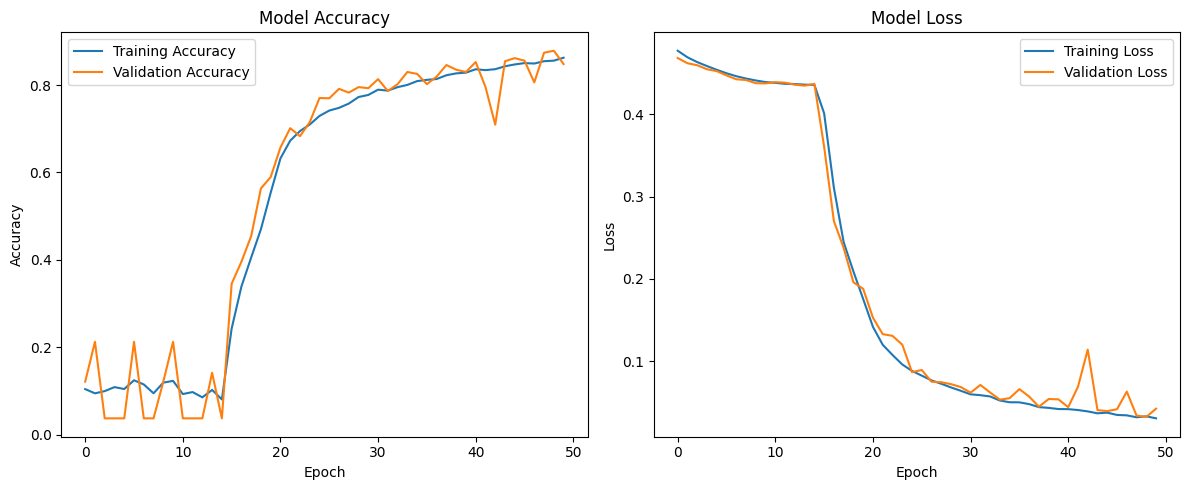

In [ ]:
plot_training_history(phase1_history, phase2_history)

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import CategoricalFocalCrossentropy

# Dummy Cast layer to avoid loading error
class Cast(Layer):
    def __init__(self, **kwargs):
        super(Cast, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(inputs, tf.float32)

# Path to your saved model
checkpoint_path = '/content/drive/MyDrive/path_to/checkpoints'
best_model_path = os.path.join(checkpoint_path, 'best_model.h5')

# Define all custom objects used in the model
custom_objects = {
    'Cast': Cast,
    'se_block': se_block,  # Ensure this function is defined/imported
    'cbam_block': cbam_block,  # Ensure this function is defined/imported
    'CategoricalFocalCrossentropy': CategoricalFocalCrossentropy()
}

# Load the .h5 model
if os.path.exists(best_model_path):
    best_model = tf.keras.models.load_model(best_model_path, custom_objects=custom_objects)
    print("Model loaded successfully.")

    # Optional: convert to .keras format
    keras_model_path = os.path.join(checkpoint_path, 'best_model.keras')
    best_model.save(keras_model_path)
    print(f"Model also saved in native Keras format at: {keras_model_path}")

    # Evaluate the model
    evaluation = best_model.evaluate(val_ds)
    print(f"Validation Loss: {evaluation[0]:.4f}")
    print(f"Validation Accuracy: {evaluation[1]:.4f}")
else:
    print("Model file not found.")




Model loaded successfully.
Model also saved in native Keras format at: /content/drive/MyDrive/path_to/checkpoints/best_model.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.8751 - loss: 0.0315
Validation Loss: 0.0323
Validation Accuracy: 0.8785


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1

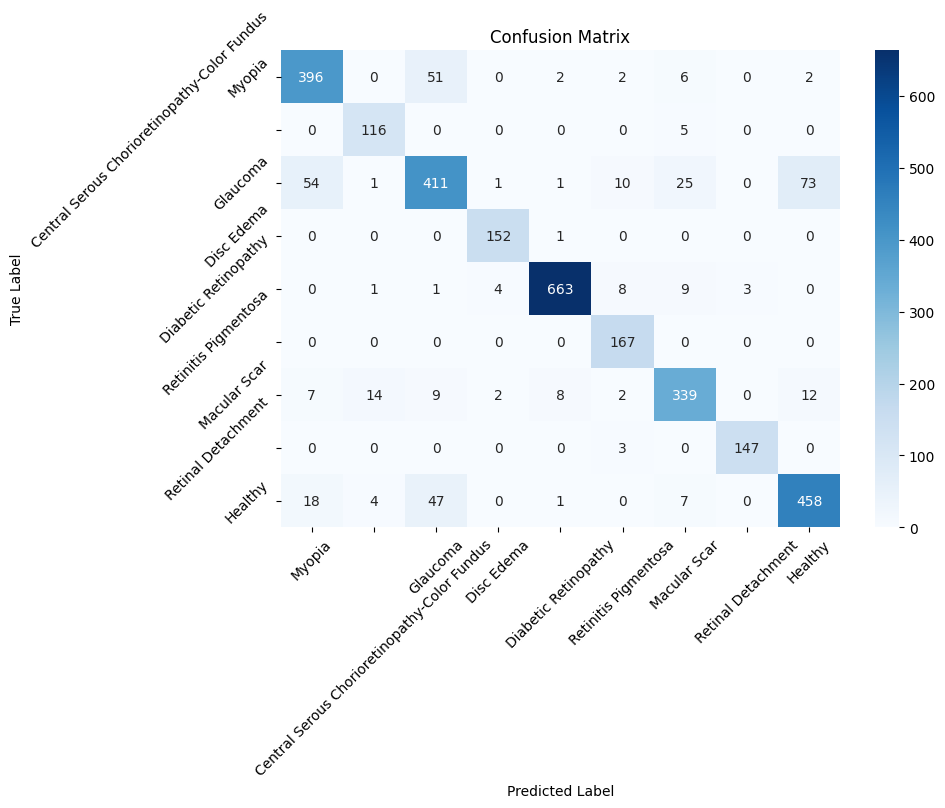


Classification Report:
                                               precision    recall  f1-score   support

                                       Myopia       0.83      0.86      0.85       459
Central Serous Chorioretinopathy-Color Fundus       0.85      0.96      0.90       121
                                     Glaucoma       0.79      0.71      0.75       576
                                   Disc Edema       0.96      0.99      0.97       153
                         Diabetic Retinopathy       0.98      0.96      0.97       689
                         Retinitis Pigmentosa       0.87      1.00      0.93       167
                                 Macular Scar       0.87      0.86      0.86       393
                           Retinal Detachment       0.98      0.98      0.98       150
                                      Healthy       0.84      0.86      0.85       535

                                     accuracy                           0.88      3243
                 

In [ ]:
# Get predictions for the validation set
predictions = []
true_labels = []

for images, labels in val_ds:
    preds = best_model.predict(images)
    predictions.extend(np.argmax(preds, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))

# Convert to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(true_labels, predictions)
fig, ax = plt.figure(figsize=(10, 8)), plt.subplot()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted class: Glaucoma (Class 2)
Confidence: 0.73


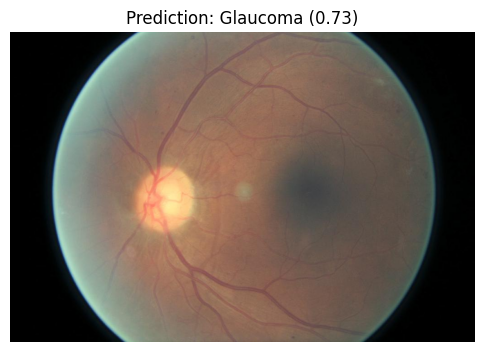

In [ ]:
# Function to make predictions on new images
def predict_image(model, image_path):
    # Read and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = apply_clahe(image)
    image = image.astype(np.float32) / 255.0

    # Expand dimensions to match model input shape
    image = np.expand_dims(image, axis=0)

    # Make prediction
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]

    return predicted_class, confidence, class_names[predicted_class]

# Example of how to use the prediction function (uncomment to use)

sample_image_path = '
class_idx, confidence, class_name = predict_image(best_model, sample_image_path)
print(f"Predicted class: {class_name} (Class {class_idx})")
print(f"Confidence: {confidence:.2f}")

# Display the image with prediction
img = cv2.imread(sample_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Prediction: {class_name} ({confidence:.2f})")
plt.axis('off')
plt.show()
